In [1]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: Oct 2, 2017

import sys
import random
import numpy as np
import cv2
import tensorflow as tf
import glob
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
import pandas as pd
import logging
import keras
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.initializers import RandomNormal, TruncatedNormal
from keras.optimizers import SGD
from keras import losses
from keras import backend as K

# Config the matplotlib backend as plotting in line in IPython
%matplotlib notebook

Using TensorFlow backend.


In [2]:
def load_data(Imagepath, Truthpath, truth_key = None):
    # Load images
    img1 = cv2.imread(Imagepath,cv2.IMREAD_UNCHANGED)
    img1_truth = cv2.imread(Truthpath,cv2.IMREAD_UNCHANGED)

    # Set labels from 0 to item_counter based upon input truth_key
    if truth_key is not None:
        item_counter = 0
        for item in truth_key:
            img1_truth[img1_truth == item ] = item_counter  # Sand
            item_counter+=1
    return img1, img1_truth

#### Normalize Image
'''Input:
    dataset: set of vectorized images, N_images x nrow x ncol x n_channels
    depth: pixel depth, float
Output:
    dataset_norm: set of vectorized normalized images, N_images x nrow x ncol x n_channels'''
def rescale(dataset, depth):
    dataset_norm = (dataset.astype(np.float32) - depth/2)/(depth/2)
    return dataset_norm

#### Randomize set of data
'''Input:
    dataset: set of images, N_images x (nrow*ncol) x n_channels
    labels: set of labels, N_images x N_labels x num_labels 
Output:
    shuffled_dataset: set of randomized images, N_images x nrow x ncol x (n_channels-n_toremove)
    shuffled_labels: set of randomized labels, N_images x N_labels
'''
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:,:]
    shuffled_labels = labels[permutation,:]
    return shuffled_dataset, shuffled_labels   

#### Generate training data as randomized
def generate_training(WholeImage, TruthImage, image_size=25, N_train=20000, N_valid = 2500, N_test = 2500, 
                      toremove = False, figureson = False):
    num_labels = len(np.unique(TruthImage))
    crop_len = int(np.floor(image_size/2))
    Truth_crop = TruthImage[crop_len:TruthImage.shape[0]-crop_len, crop_len:TruthImage.shape[1]-crop_len]
    
    # Randomly select points
    train_datasets = []
    train_labels = []
    valid_datasets = []
    valid_labels =[]
    test_datasets = []
    test_labels = []
    
    for k in range(num_labels):
        [i,j] = np.where(Truth_crop == k)
        # Training set
        idx = np.asarray(random.sample(range(len(i)), N_train)).astype(int)
        train_datasets.append([WholeImage[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
        train_labels.append([Truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])
        # Validation set
        idx = np.asarray(random.sample(range(len(i)), N_valid)).astype(int)
        valid_datasets.append([WholeImage[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
        valid_labels.append([Truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])
        # Test set
        idx = np.asarray(random.sample(range(len(i)), N_test)).astype(int)
        test_datasets.append([WholeImage[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
        test_labels.append([Truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])
        
    # Some array handling and reshaping
    train_datasets = np.asarray(train_datasets) # train_datasets is in the format of num_labels x N_train x nrows x ncols x n_channels
    train_labels = np.asarray(train_labels) # train_labels is in the format of num_labels x N_train
    valid_datasets = np.asarray(valid_datasets)
    valid_labels = np.asarray(valid_labels) 
    test_datasets = np.asarray(test_datasets) 
    test_labels = np.asarray(test_labels)
    
    train_datasets = train_datasets.reshape(num_labels*N_train, image_size, image_size, WholeImage.shape[-1]) # flatten first 2 dimensions of train_datasets
    train_labels = train_labels.reshape(num_labels*N_train,1) # flatten into vector
    valid_datasets = valid_datasets.reshape(num_labels*N_valid, image_size, image_size, WholeImage.shape[-1]) 
    valid_labels = valid_labels.reshape(num_labels*N_valid,1) 
    test_datasets = test_datasets.reshape(num_labels*N_test, image_size, image_size, WholeImage.shape[-1]) 
    test_labels = test_labels.reshape(num_labels*N_test,1)
    
    if toremove is not None:
        train_datasets = np.delete(train_datasets,toremove,-1) # Remove specific last dimension of array
        valid_datasets = np.delete(valid_datasets,toremove,-1) # Remove specific last dimension of array
        test_datasets = np.delete(test_datasets,toremove,-1) # Remove specific last dimension of y
    
    # Plot sample images of different classes
    if figureson:
        plt.figure()
        for i in range(num_labels):
            plt.axis("off")
            plt.subplot(1, num_labels, i+1)
            plt.imshow(cv2.cvtColor(train_datasets[i*N_train,:,:,0:3], cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

    train_datasets, train_labels = randomize(train_datasets, train_labels)
    valid_datasets, valid_labels = randomize(valid_datasets, valid_labels)
    test_datasets, test_labels = randomize(test_datasets, test_labels)
    
    train_datasets = rescale(train_datasets, 255)
    valid_datasets = rescale(valid_datasets, 255) 
    test_datasets = rescale(test_datasets, 255)
    
    return train_datasets, train_labels, valid_datasets, valid_labels, test_datasets, test_labels

<IPython.core.display.Javascript object>


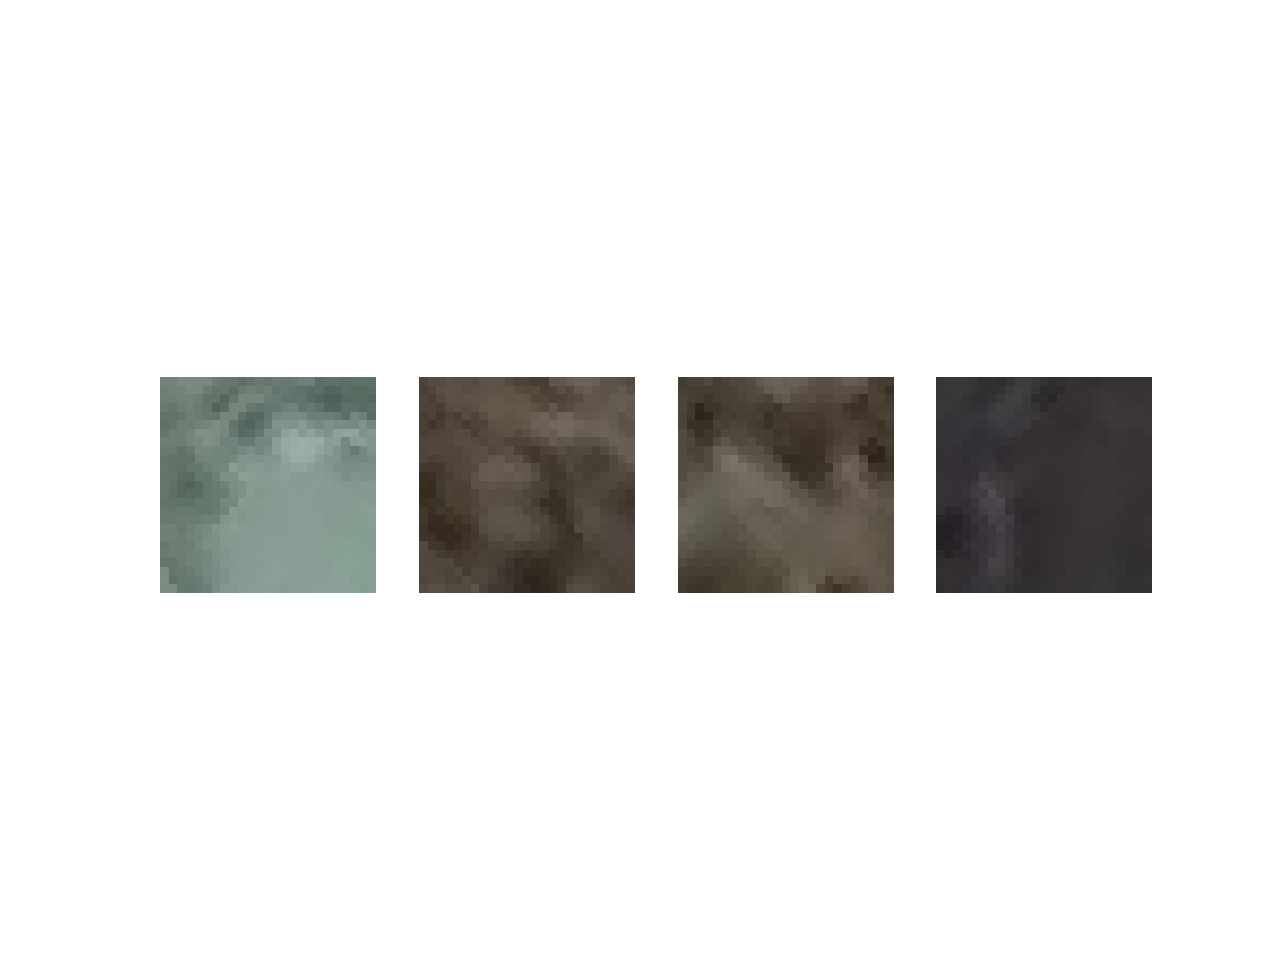

Training dataset dimensions:  (80000, 25, 25, 3) Training labels dimensions:  (80000, 1)
Validation dataset dimensions:  (10000, 25, 25, 3) Validation labels dimensions:  (10000, 1)
Test dataset dimensions:  (10000, 25, 25, 3) Test labels dimensions:  (10000, 1)


In [3]:
num_classes = 4
image_size = 25
transect1_path = '../Images/Transect 1 Hi-Res.tiff'
transect1_truth_path = '../Images/Transect 1 Truth data.tif'
Transect1, Transect1_truth = load_data(transect1_path, transect1_truth_path, truth_key=[16,160,198,38])
train_datasets, train_labels, valid_datasets, valid_labels, test_datasets, test_labels = \
    generate_training(Transect1, Transect1_truth, image_size = image_size, toremove = 3, figureson=True)

print("Training dataset dimensions: ", train_datasets.shape, "Training labels dimensions: ", train_labels.shape)
print("Validation dataset dimensions: ", valid_datasets.shape, "Validation labels dimensions: ", valid_labels.shape)
print("Test dataset dimensions: ", test_datasets.shape, "Test labels dimensions: ", test_labels.shape)

model = Sequential()
batch_size = 32
epochs = 10

if train_labels.shape[-1] != num_classes:
    train_labels = keras.utils.to_categorical(train_labels, num_classes)
    valid_labels = keras.utils.to_categorical(valid_labels, num_classes)
    test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [16]:

# datagen = ImageDataGenerator(featurewise_center = True,
#                             rescale = 1./255)
# datagen.fit(train_datasets)


# Model initiation
patch1_size = 5
stride1 = 1
patch2_size = 5
stride2 = 1
depth1 = 64
depth2 = 128
depth3 = 256
depth4 = 64
model.add(Conv2D(depth1, (patch1_size,patch1_size), strides=(stride1,stride1), activation='relu', 
                 kernel_initializer = TruncatedNormal(mean=0,stddev=0.1), input_shape=(image_size,image_size,3)))
model.add(Conv2D(depth2, (patch2_size,patch2_size), strides=(stride2,stride2), activation='relu', 
                 kernel_initializer = TruncatedNormal(mean=0,stddev=0.1)))
model.add(Flatten())
model.add(Dense(depth3, activation='relu', kernel_initializer = TruncatedNormal(mean=0,stddev=0.1)))
model.add(Dense(depth4, activation='relu', kernel_initializer = TruncatedNormal(mean=0,stddev=0.1)))
model.add(Dense(num_classes, activation = 'softmax', kernel_initializer = TruncatedNormal(mean=0,stddev=0.1)))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.fit(train_datasets, train_labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(valid_datasets, valid_labels))
score = model.evaluate(test_datasets, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#model.save('./firstKerasmodel.h5')

#sgd = SGD(lr = 0.01)
#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
#model.fit_generator(datagen.flow(train_datasets,train_labels,batch_size=batch_size,seed=1), steps_per_epoch=1000, epochs=epochs)
#score = model.evaluate_generator(datagen.flow(valid_datasets,valid_labels, batch_size=batch_size), steps=5)

Train on 80000 samples, validate on 10000 samples
Epoch 1/10
80000/80000 [==============================] - 780s - loss: 0.3351 - acc: 0.8782 - val_loss: 0.2401 - val_acc: 0.9092
Epoch 2/10
80000/80000 [==============================] - 763s - loss: 0.2324 - acc: 0.9168 - val_loss: 0.2257 - val_acc: 0.9169
Epoch 3/10
80000/80000 [==============================] - 808s - loss: 0.2061 - acc: 0.9270 - val_loss: 0.2047 - val_acc: 0.9283
Epoch 4/10
80000/80000 [==============================] - 752s - loss: 0.1903 - acc: 0.9318 - val_loss: 0.2096 - val_acc: 0.9254
Epoch 5/10
80000/80000 [==============================] - 751s - loss: 0.1761 - acc: 0.9378 - val_loss: 0.2112 - val_acc: 0.9250
Epoch 6/10
80000/80000 [==============================] - 747s - loss: 0.1623 - acc: 0.9427 - val_loss: 0.2049 - val_acc: 0.9302
Epoch 7/10
80000/80000 [==============================] - 746s - loss: 0.1512 - acc: 0.9466 - val_loss: 0.2229 - val_acc: 0.9275
Epoch 8/10
80000/80000 [=======================

In [33]:
def load_whole_data(img1, img1_truth, image_size, depth=255, offset=0, lines=None, toremove = False):
    crop_len = int(np.floor(image_size/2))
    
    if lines is None:
        lines = img1.shape[0]-2*crop_len
    
    if offset + lines + 2*crop_len > img1.shape[0]:
        print("Too many lines specified, reverting to maximum possible")
        lines = im1.shape[0] - offset - 2*crop_len
    
    whole_datasets = []
    whole_labels = []
    for i in range(offset+crop_len,lines+offset+crop_len):
        for j in range(crop_len, img1.shape[1]-crop_len):
            whole_datasets.append(img1[i-crop_len:i+crop_len+1, j-crop_len:j+crop_len+1,:])
            whole_labels.append(img1_truth[i,j])
            
    whole_datasets = np.asarray(whole_datasets) 
    whole_labels = np.asarray(whole_labels).reshape((len(whole_labels),1))
    
    if toremove is not None:
        whole_datasets = np.delete(whole_datasets,toremove,-1) # Remove specific last dimension of array
    
    whole_dataset = rescale(whole_datasets,depth)
    return whole_dataset, whole_labels

def classifyback(predictions):
    return np.argmax(predictions,1)

whole_predict = []
offstart = 0
crop_len = int(np.floor(image_size/2))
num_lines = Transect1_truth.shape[0] - 2*crop_len
for offset in range(offstart,offstart+num_lines):
    if (offset % 100 == 0):
        print('Now on step ',offset)
    temp_dataset, temp_labelset = load_whole_data(Transect1, Transect1_truth, image_size=25, offset = offset, lines=1, toremove=3)
    temp_predict = model.predict_on_batch(temp_dataset)
    whole_predict.append(classifyback(temp_predict))

whole_predict = np.asarray(whole_predict)
print(whole_predict.shape)

Now on step  0
Now on step  100
Now on step  200
Now on step  300
Now on step  400
Now on step  500
Now on step  600
Now on step  700
Now on step  800
Now on step  900
Now on step  1000
Now on step  1100
Now on step  1200
Now on step  1300
Now on step  1400
Now on step  1500
Now on step  1600
Now on step  1700
Now on step  1800
Now on step  1900
Now on step  2000
Now on step  2100
Now on step  2200
Now on step  2300
Now on step  2400
Now on step  2500
Now on step  2600
Now on step  2700
Now on step  2800
Now on step  2900
Now on step  3000
Now on step  3100
Now on step  3200
Now on step  3300
Now on step  3400
Now on step  3500
Now on step  3600
Now on step  3700
Now on step  3800
Now on step  3900
Now on step  4000
Now on step  4100
Now on step  4200
Now on step  4300
Now on step  4400
Now on step  4500
Now on step  4600
Now on step  4700
Now on step  4800
Now on step  4900
Now on step  5000
Now on step  5100
Now on step  5200
Now on step  5300
Now on step  5400
Now on step  5500
Now 

In [35]:
truth_predict = Transect1_truth[crop_len+offstart:crop_len+offstart+num_lines, crop_len:Transect1_truth.shape[1]-crop_len]
accuracy = 100*(whole_predict == truth_predict).sum()/(whole_predict.shape[0]*whole_predict.shape[1])
print('Final Accuracy %.1f%%' % (accuracy))

Final Accuracy 93.4%


<IPython.core.display.Javascript object>


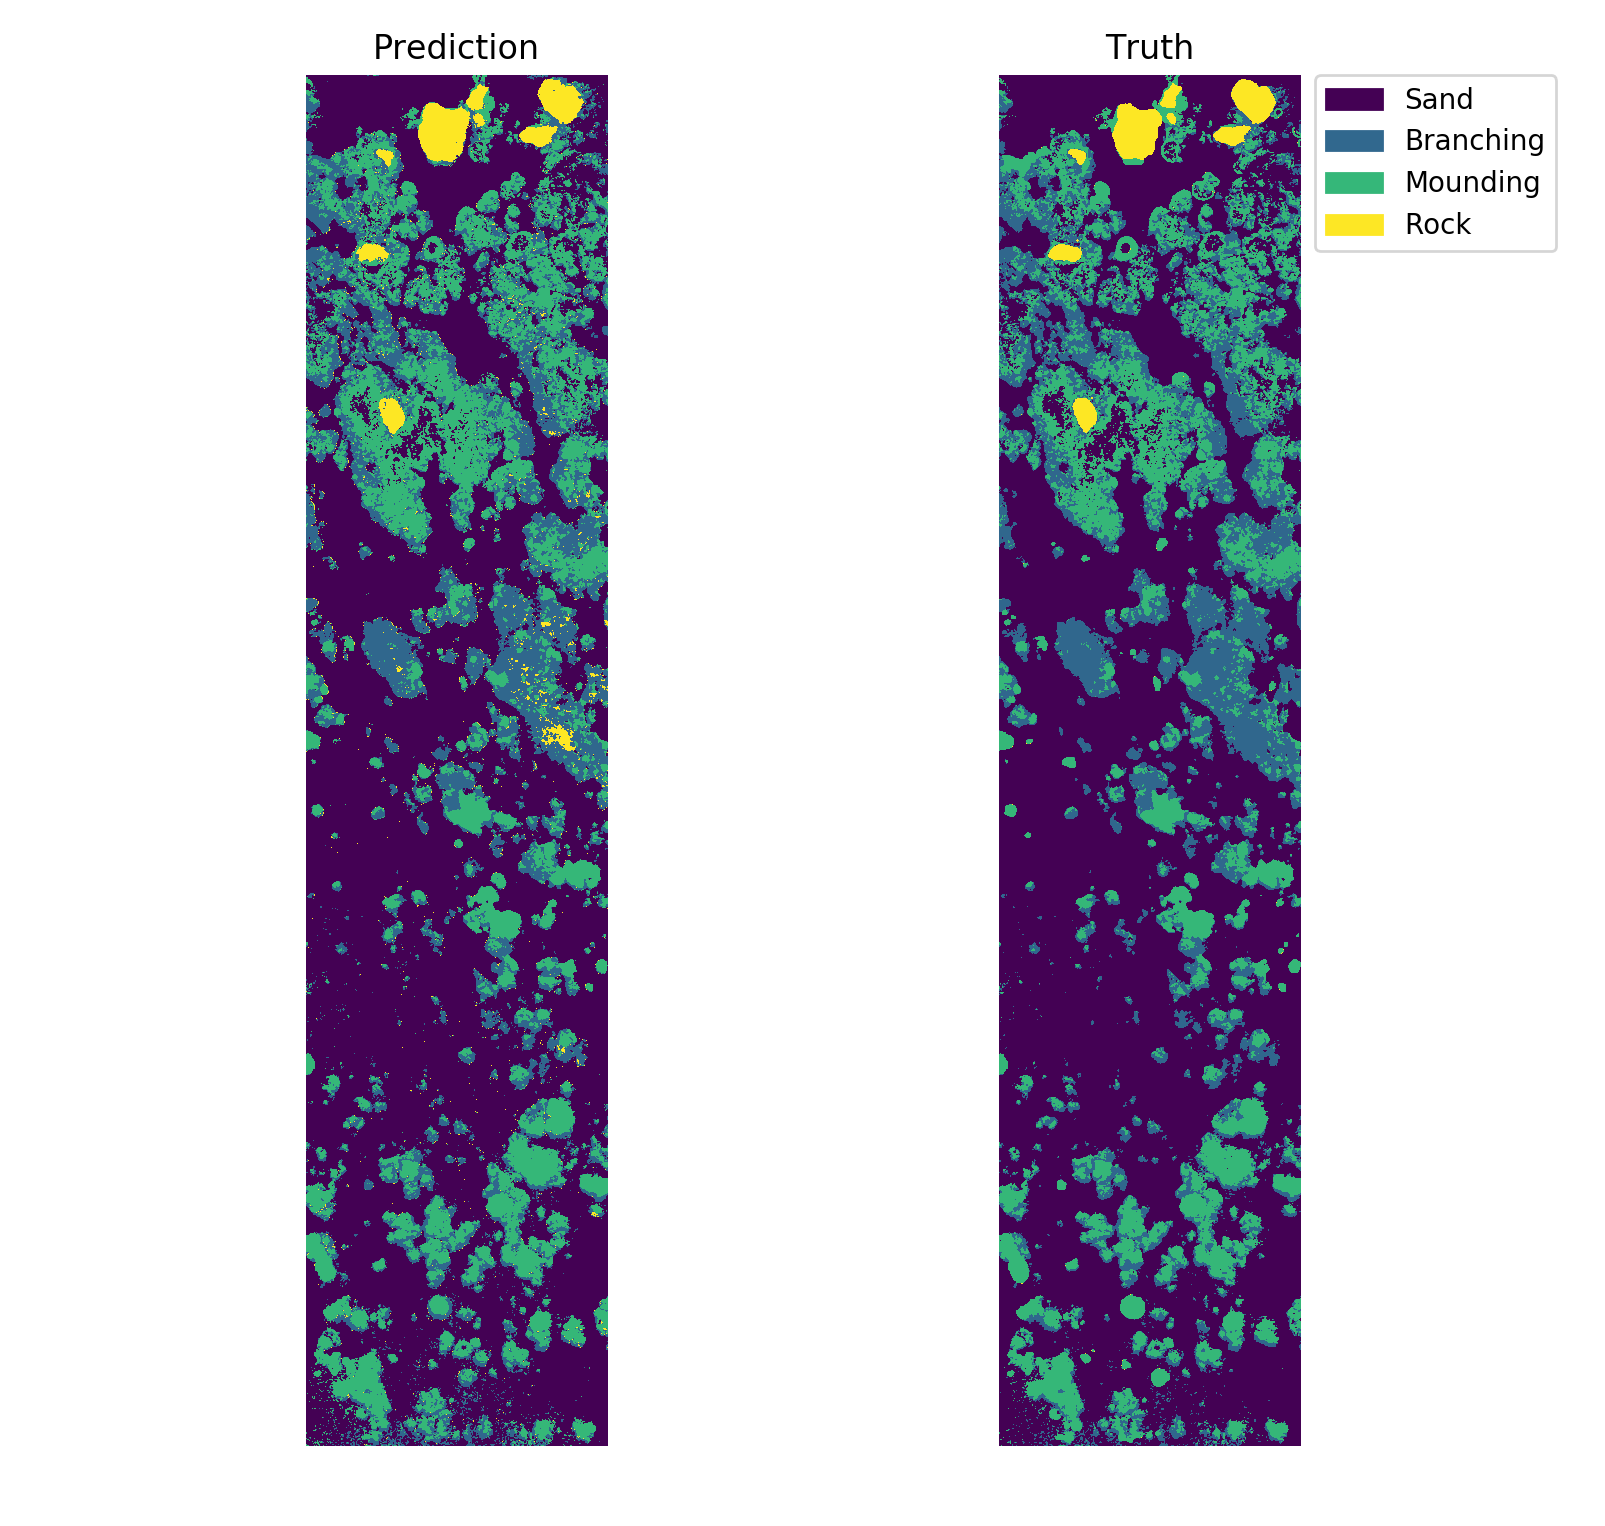

In [39]:
fig = plt.figure()
ax1 = plt.subplot(1,2,1)
ax1.imshow(whole_predict)
ax1.set_title('Prediction')
ax1.axis('off')
ax2 = plt.subplot(1,2,2)
im = ax2.imshow(truth_predict)
ax2.set_title('Truth')
ax2.axis('off')
values = np.asarray([0,1,2,3])
colors = [im.cmap(im.norm(value)) for value in values]
labels = ['Sand', 'Branching', 'Mounding', 'Rock']
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.show()

#np.save('Keras_prediction.npy',whole_predict)

In [15]:
# visualizations
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

model = load_model('firstKerasmodel.h5')
layer_dict = dict([(layer.name, layer) for layer in model.layers])

input_img = model.input

layer_name = 'conv2d_10'

kept_filters = []
for filter_index in range(0,128):
    print('Processing filter %d' % filter_index)
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:,:,:,filter_index])
    grads = K.gradients(loss, input_img)[0]
    grads = normalize(grads)
    iterate = K.function([input_img], [loss, grads])

    step = 1
    input_img_data = np.random.random((1, image_size, image_size, 3))
    input_img_data = input_img_data - 0.5

    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        #print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))


Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

NameError: name 'img_width' is not defined

<IPython.core.display.Javascript object>


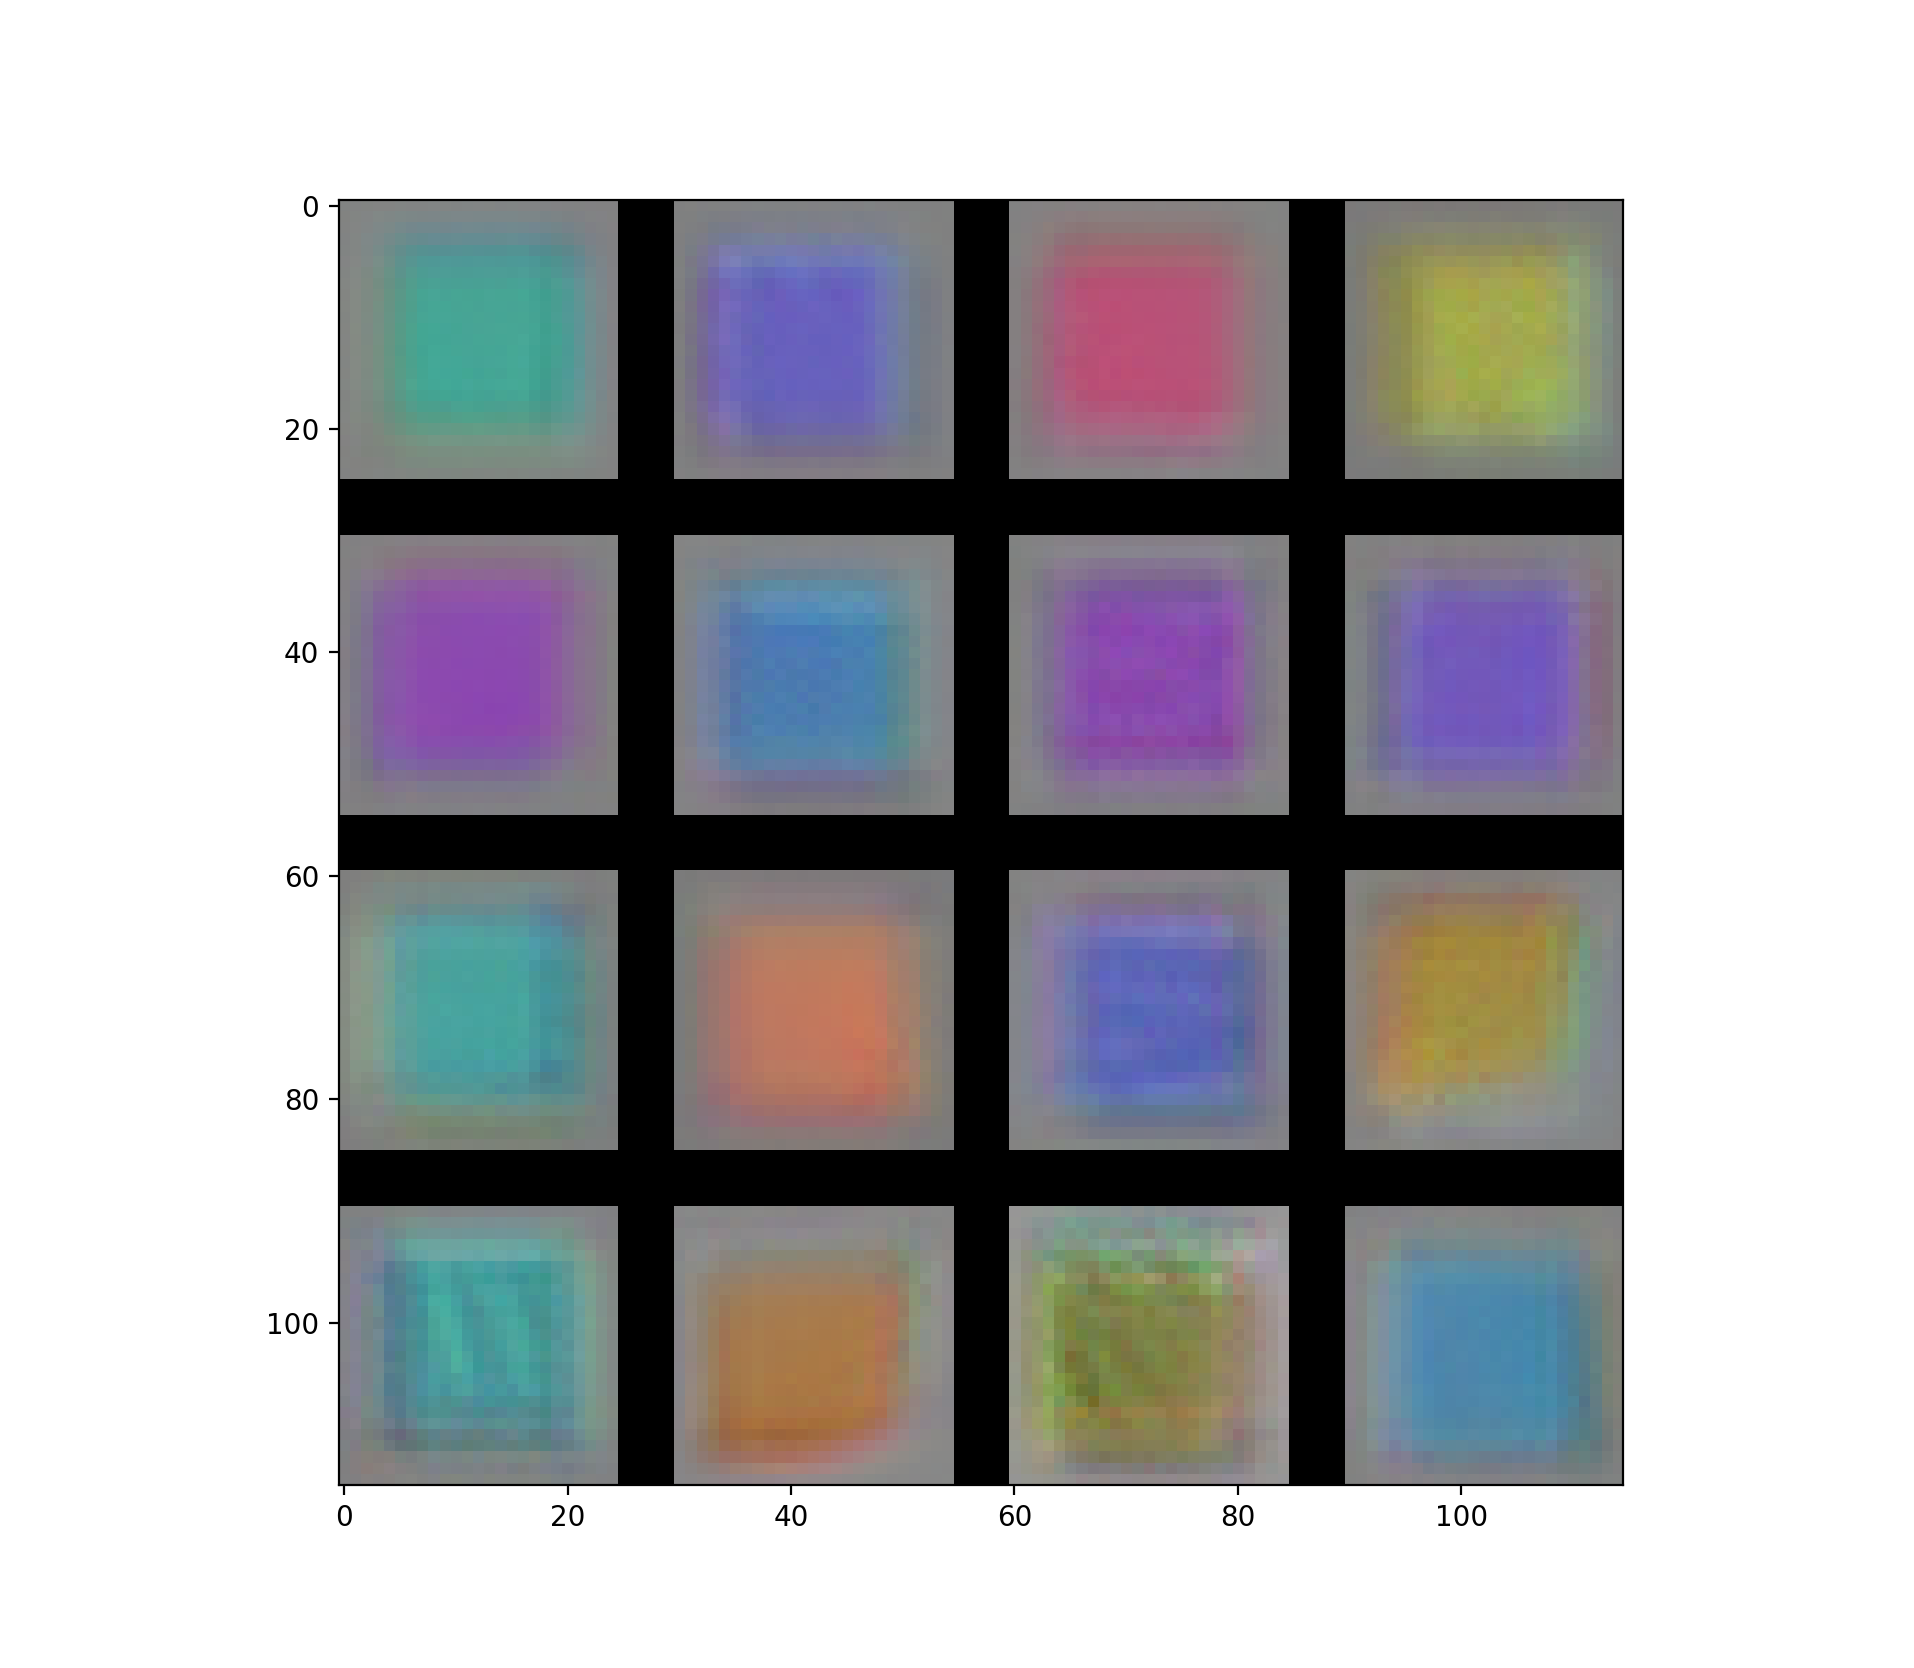

In [16]:
n = 4

kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

margin = 5
img_width = image_size
img_height = image_size
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

plt.figure()
plt.imshow(stitched_filters)
plt.show()